In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import draw, util
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import closing, disk, square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table
from scipy.signal import medfilt2d

def mask_generator_alg(dat, mask_center, mask_radius, fill_value=np.nan, add_mask=[], add_rectangular=True, showingfigure=False):
    """
    Generate mask to cover unwanted area

    Parameters
    ----------
    dat : 2D array
        Diffraction pattern.
    mask_center : 1D array, tuple, or list that contains only two values
        Center for generating mask cover unscatter electron beam.
    mask_radius : int
        Radius of the mask.
    fill_value : int, float, or nan, optional
        Value that use to fill the area of the mask. The default is np.nan.
    add_mask : list of 3-value-lists, optional
        Additional masks. Input gonna be [[x-center, y-center, radius], [...], ...] The default is [].
    add_rectangular : boolean, optional
        Additional mask with rectangular shape. The default is True.
    showingfigure : boolean, optional
        Show figure of the result of applied masks. The default is False.

    Returns
    -------
    mask : binary 2D array
        Result of all the masks in an image.

    """

    mask = np.ones(dat.shape)
    rows, cols = draw.disk((mask_center[1], mask_center[0]), mask_radius, shape=mask.shape)
    mask[rows, cols] = fill_value

    if len(add_mask)==0:
        pass
    else:
        for i in add_mask:    
            rows, cols = draw.disk((i[1], i[0]), i[2], shape=mask.shape)
            mask[rows, cols] = fill_value

    # retangular mask
    if add_rectangular==True:
        rr, cc = draw.rectangle((0,590), extent=(500,40), shape=dat.shape) # (0,535) for iodobenzene
        mask[rr, cc] = fill_value
        # 515

    if showingfigure==True:
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
        ax1.imshow(dat)
        ax2.imshow(dat*mask)

        ax1.axvline(mask_center[0], linestyle='--', lw=1, color='tab:red')
        ax1.axhline(mask_center[1], linestyle='--', lw=1, color='tab:red')

        ax2.axvline(mask_center[0], linestyle='--', lw=1, color='tab:red')
        ax2.axhline(mask_center[1], linestyle='--', lw=1, color='tab:red')

        ax1.set_title("Reference image", fontsize = 20)
        ax2.set_title("Reference image + masks", fontsize = 20)

        for ax in (ax1, ax2):
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.tight_layout()
        plt.show()

    return mask

def finding_center_alg(dat, disk_radius=3, showingfigure=False, center_guess=(532, 520), radius_guess=80, title='Reference image', thresh_input=0):
        """
        Algorithm for finding the center of diffraction pattern

        Parameters
        ----------
        dat : 2D array
            Diffraction pattern.
        disk_radius : int, optional
            Generates a flat, disk-shaped footprint. The default is 3.
        showingfigure : boolean, optional
            Show figure of the result of center finding. The default is False.
        center_guess : tuple contains 2 values, optional
            Guessing center position to generate temporary mask. The default is (532, 520).
        radius_guess : int, optional
            Guessing radius of the temporary mask. The default is 80.
        title : str, optional
            Title of the figure. The default is 'Reference image'.

        Returns
        -------
        center_x : int
            Center value on x axis.
        center_y : int
            Center value of y axis.
        radius : int
            Radius of ring used for finding center.

        """
        
        
        if thresh_input == 0:
            thresh = threshold_otsu(dat)
        else:
            thresh = thresh_input
        
        cxt, cyt = [], []
        for th in [1]:
            thresh*=th
            mask_temp = mask_generator_alg(dat, center_guess, radius_guess*th, fill_value=False, add_mask=[], add_rectangular=False, showingfigure=False)
            mask_temp = util.invert(mask_temp.astype(bool))
            bw = closing(dat > thresh, disk(disk_radius)) # Return grayscale morphological closing of an image. Square(): generate the footprint to close the gap between data points
            cleared = clear_border(bw+mask_temp)
            label_image = label(cleared)
            props = regionprops_table(label_image, properties=('centroid',
                                                             'axis_major_length',
                                                             'axis_minor_length'))
            dia = np.array([props['axis_major_length'],props['axis_minor_length']])
            dia = np.mean(dia, axis=0)
            radius = np.amax(dia)/2
            idx = np.where(dia==np.amax(dia))[0][0]
            cxt.append(props['centroid-1'][idx])
            cyt.append(props['centroid-0'][idx])
            
        center_x = np.mean(cxt)
        center_y = np.mean(cyt)
        
        
        if showingfigure==True:
            fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 10))
            ax1.imshow(dat)
            ax2.imshow(label_image)
            ax3.imshow(bw)
            
            for cc in range(len(cxt)):
                circ = patches.Circle((cxt[cc], cyt[cc]), radius, linewidth = 1, edgecolor = "r", facecolor = "none", linestyle='--')
                ax1.add_patch(circ)
                circ = patches.Circle((cxt[cc], cyt[cc]), radius, linewidth = 2, edgecolor = "r", facecolor = "none")
                ax2.add_patch(circ)
                circ = patches.Circle((cxt[cc], cyt[cc]), radius, linewidth = 2, edgecolor = "r", facecolor = "none")
                ax3.add_patch(circ)
            
            for ax in (ax1, ax2, ax3):
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            ax1.set_title(title, fontsize = 20)
            ax2.set_title("Center [X = " + str(center_x) + ", Y = " + str(center_y) + "]", fontsize = 20)
            ax3.set_title("Binary image", fontsize = 20)
            
            ax1.axvline(center_x, linestyle='--', lw=1, color='tab:red')
            ax1.axhline(center_y, linestyle='--', lw=1, color='tab:red')
            
            ax2.axvline(center_x, linestyle='--', lw=2, color='tab:red')
            ax2.axhline(center_y, linestyle='--', lw=2, color='tab:red')
            
            plt.tight_layout()
            plt.show()
        
        return center_x, center_y, radius, thresh
    

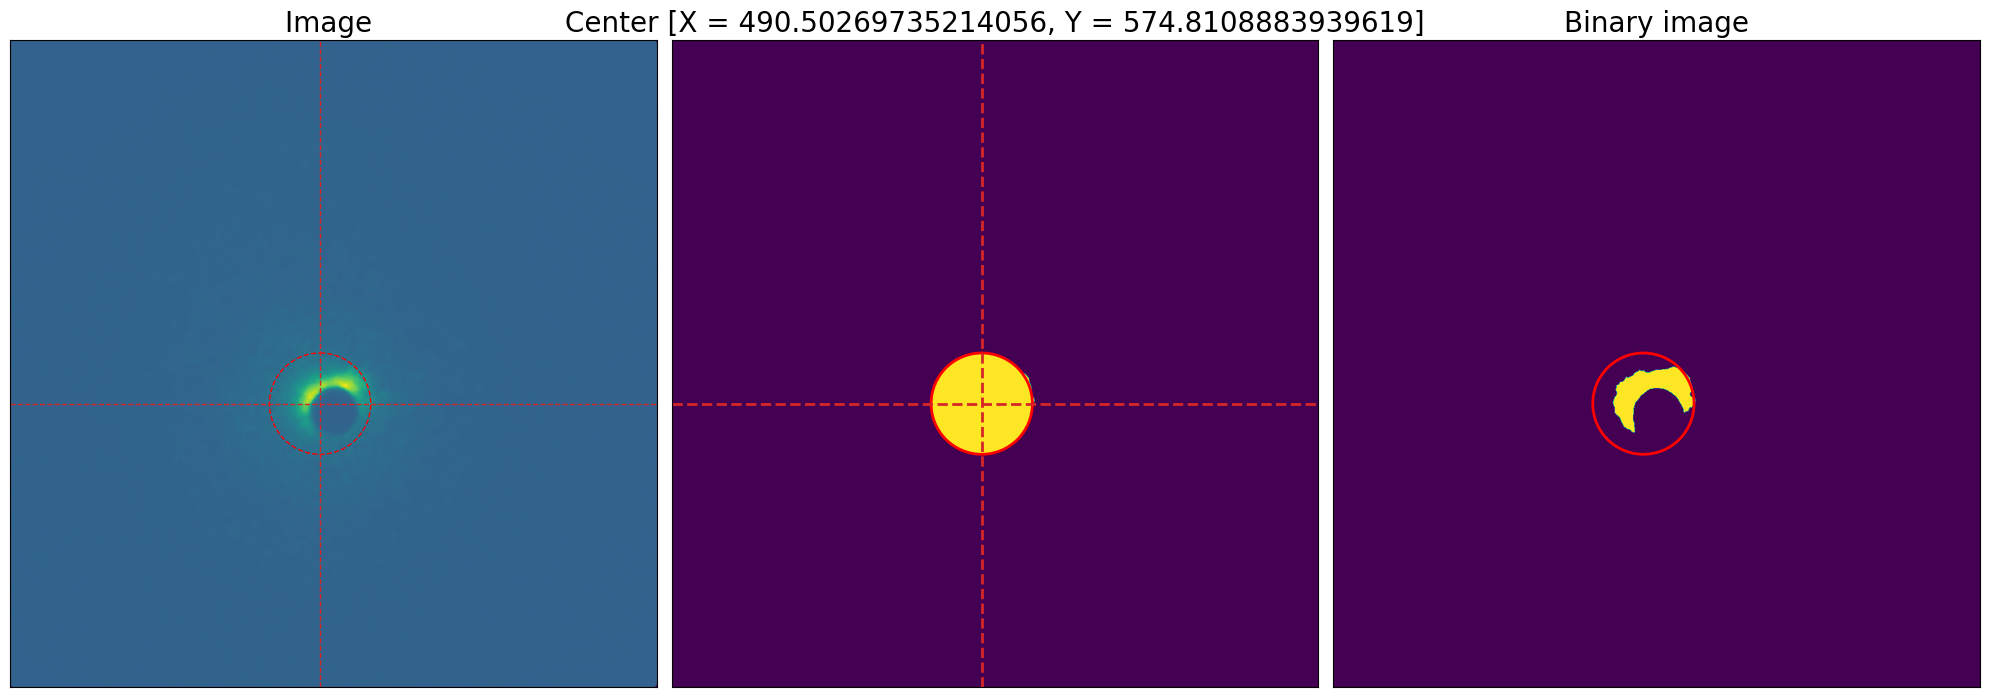

In [18]:
im = Image.open('/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/Run/20180623_2349/scan001/images-ANDOR1/ANDOR1_Throttle-001-154.6300_0001.tif')
# adjust center_guess and radius_guess if needed
center_guess = (490, 575)
radius_guess = 80

# may need to subtract background first and then apply filter and finding center
filtered_dat = medfilt2d(np.array(im), kernel_size=9)
cx, cy, _, _ = finding_center_alg(filtered_dat, disk_radius=3, showingfigure=True, center_guess=center_guess, radius_guess=radius_guess, title='Image ', thresh_input=0)
